# Main testing

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List


## Creazione dell environment

In [2]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel"))
state = env.reset()
env.render()


Be careful!  New moon tonight.                                                  
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                               .............}                                   
                          . .  ............                                     
                          ..`.  .........   }                                   
                          ....  .......    .}                                   
                          .

In [3]:
state['chars'].shape, state['pixel'].shape

((21, 79), (336, 1264, 3))

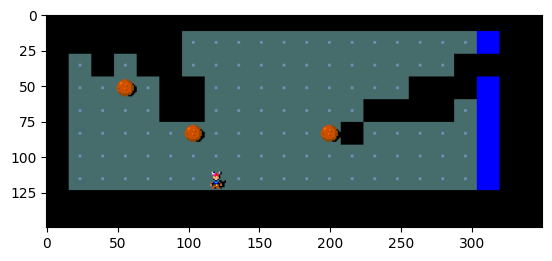

In [4]:
plt.imshow(state['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]

In [5]:
game_map = state['chars']
game = state['pixel']

## Cerco le coordinate
Cerco le coordinate del player e di tutti i blocchi presenti sulla mappa e del fiume

In [6]:
#Restituisce la lista delle posizioni di tutti i massi
def get_boulder_locationV(game_map: np.ndarray, symbol : str = "`") -> Tuple[int, int]:
    tuples = np.where(game_map == ord(symbol))
    boulders_positions = list(zip(tuples[0], tuples[1])) #converte la lista di tuple in una lista di liste
    return boulders_positions

In [7]:
#Restituisce la posizione del giocatore
def get_player_location(game_map: np.ndarray, symbol : str = "@") -> Tuple[int, int]:
    x, y = np.where(game_map == ord(symbol))
    return (x[0], y[0])

In [8]:
start = get_player_location(game_map)
boulders = get_boulder_locationV(game_map)
print("Agent position:", start)


Agent position: (13, 32)


Coordinate di tutti i blocchi presenti

In [9]:
boulders

[(9, 28), (11, 31), (11, 37)]

In [10]:
# Trovare la distanza tra due punti senza considerare movimenti diagonali
def manhattan_distance(x1 : int, y1 : int, x2 : int, y2 : int):    
    return abs(x1 - x2) + abs(y1 - y2)
    

In [11]:
# Trova la distanza fra due punti considerando anche movimenti diagonali
def chebyshev_dist(x1 : int, y1 : int, x2 : int, y2 : int): 
    y_dist = abs(y1 - y2)
    x_dist = abs(x1 - x2)
    return max(y_dist, x_dist)

In [12]:
#Trova la minima distanza tra un punto e una serie di punti considerando movimenti diagonali
def min_distance(x,y, list_of_pairs):
    min_dist = 999999999
    for i in list_of_pairs:
        dist = chebyshev_dist(x,y,i[0],i[1])
        if dist < min_dist:
            min_dist = dist
            coordinates = [i[0],i[1]]
    return coordinates, min_dist


Calcolo la distanza del player dal blocco più vicino

In [13]:
target_block_position, distance = min_distance(start[0],start[1],boulders)
print("Target position:", target_block_position, "Distance:", distance)

Target position: [11, 31] Distance: 2


### Cerco le posizioni del fiume

In [14]:
def get_river_locationV(game_map: np.ndarray, symbol : str = "}") -> Tuple[int, int]:
    tuples = np.where(game_map == ord(symbol))
    river_positions = list(zip(tuples[0], tuples[1])) #converte la lista di tuple in una lista di liste
    return river_positions

In [15]:
river_positions = get_river_locationV(game_map)

In [16]:
#Lista con le posizioni del fiume
river_positions

[(7, 44), (9, 44), (10, 44), (11, 44), (12, 44), (13, 44)]